In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.basics import *
import json
from tqdm import tqdm

import jkbc.model as m
import jkbc.utils.constants as constants
import jkbc.utils.torch_files as f
import jkbc.utils.general as g
import jkbc.utils.metrics as metric
import jkbc.utils.preprocessing as prep
import jkbc.utils.postprocessing as pop
import jkbc.utils.fasta as fasta

In [3]:
# Initialise random libs and setup cudnn
random_seed = 25 # MAGIC!!
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Constants

### Data

In [4]:
BASE_DIR = Path("../../..")
PATH_DATA = 'data/feather-files'
DATA_SET = 'Range0-50-FixLabelLen400-winsize4096'
FEATHER_FOLDER = BASE_DIR/PATH_DATA/DATA_SET

with open(FEATHER_FOLDER/'config.json', 'r') as fp:
    config = json.load(fp)

ALPHABET       = constants.ALPHABET
ALPHABET_VAL   = list(ALPHABET.values())
ALPHABET_STR   = ''.join(ALPHABET_VAL)
ALPHABET_SIZE  = len(ALPHABET.keys())
WINDOW_SIZE    = int(config['maxw']) #maxw = max windowsize
DIMENSIONS_OUT = int(config['maxl']) # maxl = max label length
STRIDE         = WINDOW_SIZE

KNOWLEGDE_DISTILLATION = True
TEACHER_OUTPUT = 'bonito-csv' # Set to name of y_teacher output
if KNOWLEGDE_DISTILLATION and not TEACHER_OUTPUT:
    print('WARNING! Must provide name of teacher output when doing knowledge distillation')

### Train/Predict

In [5]:
LR = 1e-3  # default learning rate
BS = 2**6  # batch size
EPOCHS = 400
DEVICE = torch.device("cuda:0") #torch.device("cpu")

### Model

In [6]:
import bonito_basic as model_file
DIMENSIONS_PREDICTION_OUT = WINDOW_SIZE//3+1
DROP_LAST = False # SET TO TRUE IF IT FAILS ON LAST BATCH
model, MODEL_NAME = model_file.model(DEVICE, WINDOW_SIZE, DIMENSIONS_PREDICTION_OUT)
MODEL_NAME = f'{MODEL_NAME}-student'
MODEL_DIR = f'weights/{MODEL_NAME}'
model_weights = None#'bestmodel_8' #'bonito-pretrained-Valid[1.545677900314331]-CTC[91.66666666666667]' #Set to specific name of model ('None' uses the newest)

In [ ]:
# Run to get newest model
if not model_weights:
    model_weights = g.get_newest_model(MODEL_DIR)

### Loss, metrics and callback

In [7]:
_ctc_loss = metric.CtcLoss(WINDOW_SIZE, DIMENSIONS_PREDICTION_OUT, BS, ALPHABET_SIZE)
_kd_loss = metric.KdLoss(alpha=.05, temperature=20, label_loss=_ctc_loss)
LOSS_FUNC = _kd_loss.loss() if KNOWLEGDE_DISTILLATION else _ctc_loss.loss()
#LOSS_FUNC = nn.CTCLoss()
METRICS = [metric.ctc_accuracy(ALPHABET, 5)]
SAVE_CALLBACK = partial(metric.SaveModelCallback, every='epoch', monitor='ctc_accuracy')

## Load data

In [8]:
# Read data from feather
if KNOWLEGDE_DISTILLATION:
    data, teacher = f.load_training_data_with_teacher(FEATHER_FOLDER, TEACHER_OUTPUT)
    train_dl, valid_dl = prep.convert_to_dataloaders(data, split=.8, batch_size=BS, teacher=teacher, drop_last=DROP_LAST)
else:
    data = f.load_training_data(FEATHER_FOLDER) 
    train_dl, valid_dl = prep.convert_to_dataloaders(data, split=.8, batch_size=BS, drop_last=DROP_LAST)

# Convert to databunch
databunch = DataBunch(train_dl, valid_dl, device=DEVICE)

## Model

In [9]:
optimizer = partial(torch.optim.AdamW, amsgrad=True, lr=LR)

In [10]:
learner = Learner(databunch, model, loss_func=LOSS_FUNC, model_dir=MODEL_DIR, metrics=METRICS, opt_func=optimizer)

In [11]:
try:
    learner.load(model_weights)
    print(f'{model_weights} loaded')
except:
    print(f'No model could be found')

No model could be found


## Train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 7.59E-02


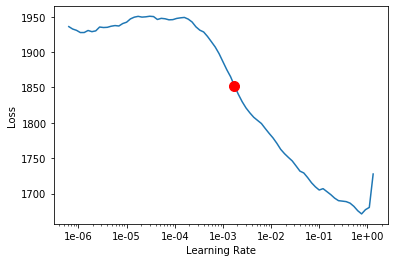

In [12]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [13]:
# Default to LR if lr_find() has not been run
try: lr = learner.recorder.min_grad_lr
except: lr = LR
lr

0.001737800828749376

In [ ]:
learner.fit(EPOCHS, lr=lr, callbacks=[SAVE_CALLBACK(learner), metric.CSVLogger(learner)])

epoch,train_loss,valid_loss,ctc_accuracy,time
0,1463.243164,1452.351807,0.620568,00:32
1,1359.600342,1286.860107,0.598421,00:33
2,1275.228149,1224.153076,0.582993,00:33
3,1196.493530,1295.357666,0.589449,00:33
4,1120.927612,1310.330200,0.589607,00:33
5,1061.054565,1409.774170,0.678531,00:33
6,1008.252380,1123.855835,0.620796,00:33
7,950.265564,1212.600952,0.637957,00:33
8,888.442993,1202.024048,0.618202,00:33
9,824.211060,1176.034302,0.623543,00:33


In [ ]:
learner.recorder.plot_losses()